# Hands-on 01: Data generation using simple models

In this tutorial, you will learn:
- how to load a mesh
- how to generate data on a mesh
- how different parameters can affect the data

We first start with loading a standard mesh. For the time being, let us use a 2D disk example. The standard mesh is the most commonly used type, e.g. in fNIRS and DOT. The meanings of the other two types will explained in the latter parts of this tutorial.

**NOTES:**

- Depending on the Matplotlib backend you are using, you might encounter issues with the plt.show() function, in which case you can simply delete/comment out all plt.show() lines. You may also have issues with the animations, but this is not really essential in the tutorial, and you may skip the animation parts. Further information on the backends: https://matplotlib.org/stable/users/explain/figure/backends.html
- You will see warnings stating "RuntimeWarning: divide by zero encountered in log" here and there. This is because we are also plotting voxels outside of the mesh, which have zero values, and the log function draws your attention to it. It is safe to ignore them.

## Continuous-wave data generation

First let's load the necessary pacakges

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Step 1: let's load an example mesh

In [3]:
mesh = ff.base.stndmesh()
mesh.from_file('../meshes/standard/circle2000_86_stnd')

Fixed sources
Sources integration functions loaded
Fixed detectors
Detectors integration functions loaded


Essentially, what we need to do is to first create an object of the appropriate class, and then call the relevant method to populate its fields. 

In the printout, "fixed" sources and detectors mean that the locations of the optodes shall remain *exactly* where they are defined to be without checking, even though they might be placed outside of the mesh by mistake. Integration functions define the relationship between an optode and the nodes in the mesh: the calculations done on a FEM mesh are defined only on the nodes in the mesh, but suppose an optode is NOT placed on a node but in the middle of a triangle/tetrahedron (an "element") what should we do? The solution is to define the fluence at the optode as a weighted average of nodes of the element it is in, and the weights are called "integration functions". For the curious reader, they are exactly the "Barycentric coordinates".

The package can, of course, also take care of non-fixed sources (which is in fact to be recommended in most cases) and calculate these integration functions.

We can take a look at what attributes the mesh object contains

In [4]:
print(mesh.__dict__.keys())

dict_keys(['name', 'nodes', 'bndvtx', 'type', 'mua', 'kappa', 'ri', 'mus', 'elements', 'dimension', 'region', 'source', 'meas', 'link', 'c', 'ksi', 'element_area', 'support', 'vol'])


This is a circular disk mesh with 16 sources and 16 detectors, forming 240 channels. We can view the optode locations and the channel information like this,

In [5]:
print('source locations (x, y) in millimeters')
print(mesh.source.coord)
print('detector locations (x, y) in millimeters')
print(mesh.meas.coord)
print('channels [source, detector, active_or_not]')
print(mesh.link)

source locations (x, y) in millimeters
[[ 41.1885   -8.19295]
 [ 34.9146  -23.3293 ]
 [ 23.3276  -34.9121 ]
 [  8.19192 -41.1834 ]
 [ -8.19192 -41.1834 ]
 [-23.3276  -34.9121 ]
 [-34.9146  -23.3293 ]
 [-41.1885   -8.19285]
 [-41.1885    8.19295]
 [-34.9146   23.3293 ]
 [-23.3276   34.9121 ]
 [ -8.19192  41.1834 ]
 [  8.19192  41.1834 ]
 [ 23.3276   34.9121 ]
 [ 34.9146   23.3293 ]
 [ 41.1885    8.19295]]
detector locations (x, y) in millimeters
[[ 42.1271   -8.37965]
 [ 35.7103  -23.8609 ]
 [ 23.8593  -35.7078 ]
 [  8.37863 -42.122  ]
 [ -8.37863 -42.122  ]
 [-23.8593  -35.7078 ]
 [-35.7103  -23.8609 ]
 [-42.1271   -8.37955]
 [-42.1271    8.37965]
 [-35.7103   23.8609 ]
 [-23.8593   35.7078 ]
 [ -8.37863  42.122  ]
 [  8.37863  42.122  ]
 [ 23.8593   35.7078 ]
 [ 35.7103   23.8609 ]
 [ 42.1271    8.37965]]
channels [source, detector, active_or_not]
[[ 1  2  1]
 [ 1  3  1]
 [ 1  4  1]
 [ 1  5  1]
 [ 1  6  1]
 [ 1  7  1]
 [ 1  8  1]
 [ 1  9  1]
 [ 1 10  1]
 [ 1 11  1]
 [ 1 12  1]
 [ 1 13

Step 2: let's define a regular grid, on which the data will be represented

In [6]:
# The grids are: from -45mm to +45mm, with 2mm resolution
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
# Feed the grid to the mesh,and let it generate the necessary information to convert data to the grid
mesh.gen_intmat(xgrid, ygrid)

Step 3: let's generate the data!

For CW and FD data, the syntax is,
    data, convergence_info = mesh.femdata(frequency)

In [7]:
data, info = mesh.femdata(0)

We can have a look at what the data object and the info (that is, convergence information of the FEM solver) object contains

In [8]:
print(data.__dict__.keys())
print(info.__dict__.keys())

dict_keys(['phi', 'complex', 'link', 'amplitude', 'phase', 'vol'])
dict_keys(['isConverged', 'isConvergedToAbsoluteTolerance', 'iteration', 'residual'])


Let's focus on data in this tutorial. *phi* is fluence field in the mesh, calculated per source (so we have 16 in this example), *complex* is the measured intensity at boundary per channel (so we have 240 in this example), *link* is copied from mesh.link, *amplitude* is the absolute value of *complex*, *phase* is the phase delay at boundary per channel (all zero in CW, but will become relevant shortly), and *vol* contains the information to convert data to the grid.

**Now let's plot the fluence for source 0**

/var/folders/x8/cr7bc06s70z4snmwjhnncdkw0000gn/T/ipykernel_17296/1018914111.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(data.phi[:,:,0])), origin='lower', vmin=-16, vmax=0) # the number 0 here selects source number 0


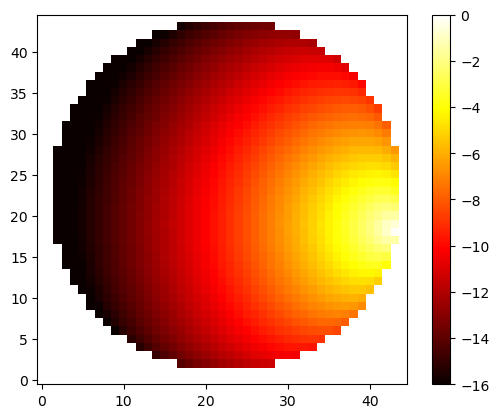

In [9]:
plt.imshow(np.log(np.abs(data.phi[:,:,0])), origin='lower', vmin=-16, vmax=0) # the number 0 here selects source number 0
plt.set_cmap('hot')
plt.colorbar()

You can ignore the divide by zero warning because the grid is bigger than the mesh, so the grid points sitting outside of the mesh will have zero values. 

### Exercise 0
Now that we have learned how to visualize the fluence field of one source, please try to do the same with the other sources.

### Exercise 1

Recall from the lecture: the absorption coefficient dictates how quickly the light decays in the medium. We can now try to build some intuition by simulating the effects.

To do so, we can scale the absorption coefficients (globally and uniformly for now), and repeat the simulation. Below is an example and your task is to vary the scaling and observe what effects it has.

In [10]:
# let's make a duplicate of the mesh, so we don't make a mess of the original!
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)

/var/folders/x8/cr7bc06s70z4snmwjhnncdkw0000gn/T/ipykernel_17296/1865449468.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(data2.phi[:,:,0])), origin='lower', vmin=-16, vmax=0) # the number 0 here selects source number 0


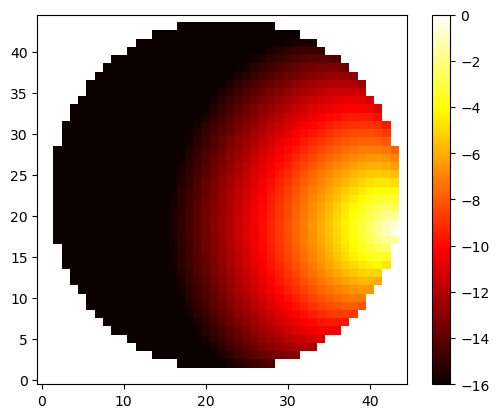

In [11]:
# now change the absorption coefficient
new_mua = 2*mesh.mua[0] # e.g. 2 times the original
# this function changes the optical properties properly
# -1 means all the nodes in the mesh, the new properties are given as [mua, mus, ri]
mesh2.change_prop(-1, [new_mua, mesh.mus[0], mesh.ri[0]])
data2 = mesh2.femdata(0)[0] # we can do this if we don't care about the convergence information

# plot
plt.imshow(np.log(np.abs(data2.phi[:,:,0])), origin='lower', vmin=-16, vmax=0) # the number 0 here selects source number 0
plt.set_cmap('hot')
plt.colorbar()

## Frequency-domain data generation

Now let's move on to FD data. The syntax for generating FD data is exactly the same, except that we have use a non-zero frequency instead. For example, if we use 100 MHz modulation frequency, we can do something like this,

In [12]:
data = mesh.femdata(1e8)[0] # 1e8 Hz, i.e. 100 MHz

If we recall from the lecture, FD data contains two pieces of information: the amplitude and the phase. Both of them can be extracted from the data.phi field, which is now a complex number. We can still plot the fluence amplitude distribution as we did previously

/var/folders/x8/cr7bc06s70z4snmwjhnncdkw0000gn/T/ipykernel_17296/1018914111.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(data.phi[:,:,0])), origin='lower', vmin=-16, vmax=0) # the number 0 here selects source number 0


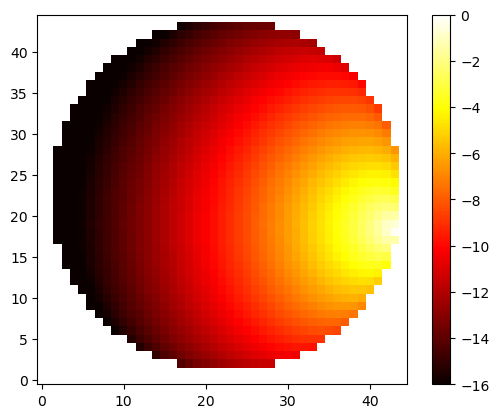

In [13]:
plt.imshow(np.log(np.abs(data.phi[:,:,0])), origin='lower', vmin=-16, vmax=0) # the number 0 here selects source number 0
plt.set_cmap('hot')
plt.colorbar()

There is not too much difference, because of the relatively low the modulation frequency (yes, 100MHz is still considered relatively low, because we are comparing with $c\mu_a$ where $c$ is the light speed).

### Exercise 2
Now it is time to look at the second piece of information: the phase. Plotting the phase is very much the same as plotting the amplitude, except that instead of calculating the absolute value of *phi*, you calculate its phase. You can also try to repeat for different sources.

*Hint 1: the function for calculating phase is np.angle(), which returns in radians*

*Hint 2: you should certainly get rid of np.log when plotting*

*Hint 3: it's probably a good idea to modify, or get rid of vmin and vmax if you copy the previous plotting code, because the range of the data is very different now*

### Exercise 3

Now please change the modulation frequency, and observe how the phase distribution changes. The question you may want to think about is: what happens if the modulation frequency is too low? And what if it's too high?

## Time resolved data generation

NIRFASTerFF can generate two types time-resolved data: the TPSF and the moments (that is, directly, without having to calculate the TPSF first). In this workshop we will focus on the TPSF generation, which will also be used in the later parameter recovery session.

The syntax is now, *data,info=mesh.femdata_tpsf(tmax,tstep)*, where tmax is the total amount of time to simulate, and tstep is the temporal resolution.

In [14]:
data = mesh.femdata_tpsf(5e-9, 1e-11)[0] # that is, 5 ns total, at 0.01ns resolution

Now instead of visualizing the internal fluence, let's have a look at the TPSFs recorded at each channel. To make things simple, we will focus on channels 2-4, i.e. channels formed between source 1 and detectors 3-5. Let's have a look at the optode locations first, so we have a better idea of what we will be looking at.

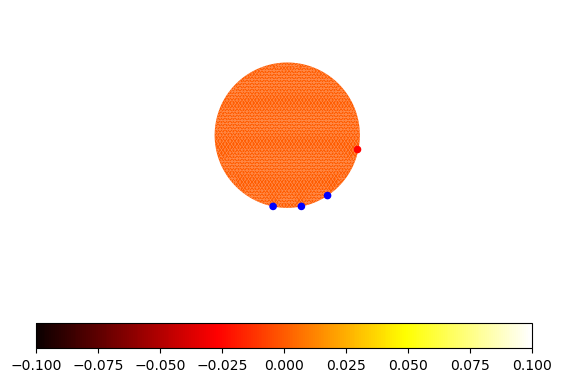

In [15]:
fig,ax = ff.visualize.plotimage(mesh)
ax.scatter(mesh.source.coord[0,0], mesh.source.coord[0,1], color='r')
ax.scatter(mesh.meas.coord[2:5,0], mesh.meas.coord[2:5,1], color='b')

where the blue dots are the detectors, numbered counter-clockwise.

Now we can plot the TPSFs in one figure, and make some observations.

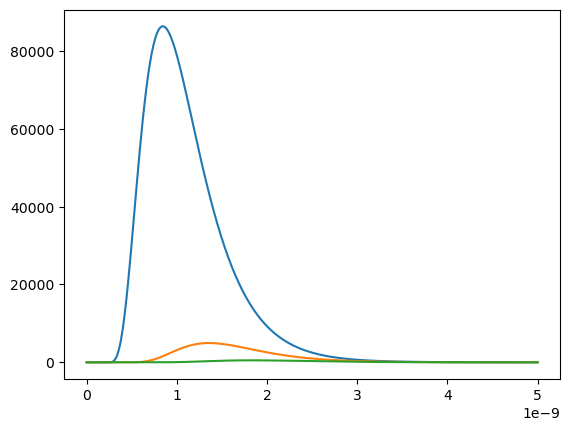

In [16]:
plt.plot(data.time, data.tpsf[1:4,:].T)

So we can observe two things: the peak height reduces dramatically with distance, and the peak time delays with distance.

### Exercise 4

Now recall how we observed the impact of absorption coefficient on internal fluence. In this exercise, please change the absorption coefficients the same way, and see how the boundary TPSF changes - specifically, pay attention to the widths, peaking time, and the relative peak heights of the three channels.

In [17]:
# let's make a duplicate of the mesh, so we don't make a mess of the original!
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)

In [18]:
# continue from here

### Exercise 5

Choosing the right step size when calculating the TPSF can be tricky: if too small, it takes forever to finish, and if too big, the resolution (and even stability!) will be compromised.

In this exercise, please change the temporal resolution (i.e., the second argument when calculating the TPSF) and observe how it affects the resulting TPSFs. Specifically pay attention to when it is dramatically (>10 times) larger. 